In [6]:
%run _utils.ipynb

In [7]:
issues = load_issues()
comments = load_comments()

In [54]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365625 entries, 0 to 365624
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   comment_issue_url           365625 non-null  object             
 1   comment_issue_id            365625 non-null  int64              
 2   comment_id                  365625 non-null  int64              
 3   comment_url                 365625 non-null  object             
 4   comment_created_at          365625 non-null  datetime64[ns, UTC]
 5   comment_updated_at          365625 non-null  datetime64[ns, UTC]
 6   comment_body                365624 non-null  object             
 7   comment_author_association  365625 non-null  object             
 8   comment_user_id             365625 non-null  int64              
 9   comment_user_login          365625 non-null  object             
 10  comment_user_type           365625 non-null 

<h3>Load <code>all_issues</code></h3>
<p>NOTE that this includes every single issue from every single repo in the list of repos from the GK In-range breaking build issues set</p>

Count=2398438 (Project Count=12017) Median=55.0 Mean=199.58708496296913


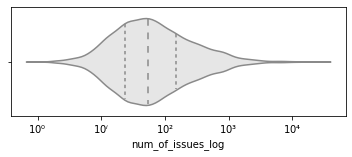

In [8]:
all_issues = load_all_issues()
counts = all_issues.groupby('repo_name')['id'].count()
print(f"Count={len(all_issues)} (Project Count={len(counts)}) Median={counts.median()} Mean={counts.mean()}")
for_plot = counts.to_frame(name='num_of_issues')
for_plot['placeholder'] = ''
for_plot['num_of_issues_log'] = np.log10(for_plot['num_of_issues'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=for_plot,
    x='num_of_issues_log',
    y='placeholder',
    inner='quartile',
    palette=['0.9'],
    logscale=True
)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(log10_func_formatter)
plt.show()

<h3>Create data sets of <code>non_gk_issues</code> and <code>gk_issues</code></h3>
<p>
    For analysis, we ignore gk_issues that we dont have all issues for, and remove the duplicate gk_issues from the all_issues data set
</p>

In [13]:
def filter_issues_for_analyses(all_issues, gk_issues):
    # Make copies
    gk_issues_for_analysis = gk_issues.copy()
    non_gk_issues_for_analysis = all_issues.copy()
    # Remove pull requests from all issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['is_pull_request']
    ]
    # Filter out any issues that are GK in-range breakin gbuild issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['id'].isin(gk_issues_for_analysis['id'])
    ]
    # Only analyze GK issues for projects we have all issues for
    gk_issues_for_analysis = gk_issues_for_analysis[
        gk_issues_for_analysis['repo_name'].isin(non_gk_issues_for_analysis['repo_name'])
    ]
    # Copy the html_url and body attributes over from all_issues to their respective rows on gk_issues
    gk_issues_for_analysis = gk_issues_for_analysis.merge(
        all_issues[['id', 'html_url', 'body']],
        how='left',
        on='id',
    )
    return non_gk_issues_for_analysis, gk_issues_for_analysis
    

non_gk_issues, gk_issues = filter_issues_for_analyses(all_issues, issues)

<h3><b><i>How many comments do in-range breaking build issue reports have in total, from GK and from actual developers?</i></b></h3>

In [14]:
comments['comment_user_login'].value_counts()

greenkeeper[bot]    354196
ljharb                 598
ryanhefner             379
gr2m                   261
derhuerst              198
                     ...  
kylecordes               1
talentlessguy            1
kwonoj                   1
ishegg                   1
theKashey                1
Name: comment_user_login, Length: 1607, dtype: int64

In [15]:
proportions = (
    comments['comment_user_login'].value_counts() / 
    comments['comment_user_login'].count()
).to_frame(name='proportion')\
    .rename_axis('comment_user_login')\
    .reset_index()
print(proportions.head())

def get_issue_comment_count(df):
    return df.groupby('comment_issue_id')['comment_id']\
        .count()\
        .to_frame(name='num_of_comments')\
        .reset_index()

counts = get_issue_comment_count(comments)
user_counts = get_issue_comment_count(comments[comments['comment_user_type'] == 'User']).rename(columns={'num_of_comments': 'user_comments_count'})
bot_counts = get_issue_comment_count(comments[comments['comment_user_type'] == 'Bot']).rename(columns={'num_of_comments': 'bot_comments_count'})
gk_counts = (
    get_issue_comment_count(
        comments[
            (comments['comment_user_type'] == 'Bot') &
            (comments['comment_user_login'] == 'greenkeeper[bot]')
        ]
    ).rename(
        columns={'num_of_comments': 'gk_comments_count'}
    )
)


counts = (
    counts.merge(
        user_counts,
        how='left',
        on='comment_issue_id'
    ).merge(
        bot_counts,
        how='left',
        on='comment_issue_id'
    ).merge(
        gk_counts,
        how='left',
        on='comment_issue_id'
    ).fillna(0)
)
counts['user_comments_count'] = counts['user_comments_count'].astype(int)
counts['bot_comments_count'] = counts['bot_comments_count'].astype(int)
tfns(counts, ['num_of_comments', 'user_comments_count', 'bot_comments_count', 'gk_comments_count'], should_round=False, title='Number of comments on In-Range issues')


  comment_user_login  proportion
0   greenkeeper[bot]    0.968741
1             ljharb    0.001636
2         ryanhefner    0.001037
3               gr2m    0.000714
4          derhuerst    0.000542
Number of comments on In-Range issues      Count      Mean       STD    Min    25%    Median    75%    Max
---------------------------------------  -------  --------  --------  -----  -----  --------  -----  -----
num_of_comments                            99581  3.67163   5.40044       1      1         2      4     30
user_comments_count                        99581  0.107691  0.383286      0      0         0      0     28
bot_comments_count                         99581  3.56394   5.41808       0      1         1      3     30
gk_comments_count                          99581  3.55686   5.4184        0      1         1      3     30



<h3>User Comments Analysis</h3>

In [16]:
users_comments = comments[comments['comment_user_type'] == 'User'].copy().reset_index(drop=True)
issues_with_user_comment = \
    gk_issues[gk_issues['id']\
        .isin(users_comments['comment_issue_id'])]\
        .copy()\
        .reset_index(drop=True)
percent_of_issues_with_user_comment = f'{calculate_percent(len(issues_with_user_comment), len(gk_issues))}%'
print(f'{percent_of_issues_with_user_comment} of in-range issues have a comment from a user.')

9.3% of in-range issues have a comment from a user.


<h3><b><i>How long does it take for users to comment?</i></b></h3>

                   Count  Mean              STD               Min              25%              Median           75%               Max
---------------  -------  ----------------  ----------------  ---------------  ---------------  ---------------  ----------------  ------------------
time_to_comment     9652  25 days 17:24:11  65 days 08:20:06  0 days 00:00:01  0 days 08:17:24  2 days 12:57:58  18 days 16:46:52  1039 days 05:34:55



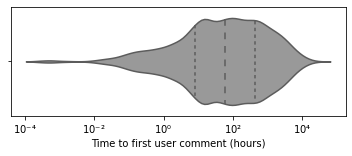

In [18]:
users_comments_simplified = users_comments[['comment_issue_id', 'comment_created_at']]
users_comments_simplified = \
    users_comments_simplified\
        .groupby('comment_issue_id')['comment_created_at']\
        .min()\
        .to_frame()\
        .reset_index()
issues_simplified = gk_issues[['id', 'created_at', 'repo_name']]

gk_issues_with_first_user_comments = issues_simplified.merge(
    users_comments_simplified,
    left_on='id',
    right_on='comment_issue_id'
)
gk_issues_with_first_user_comments['time_to_comment'] = \
    gk_issues_with_first_user_comments['comment_created_at'] - gk_issues_with_first_user_comments['created_at']

gk_issues_with_first_user_comments['time_to_comment_hours'] = \
    gk_issues_with_first_user_comments['time_to_comment'] / np.timedelta64(1, 'h')
gk_issues_with_first_user_comments = \
    gk_issues_with_first_user_comments[~(gk_issues_with_first_user_comments['time_to_comment_hours'] == 0)]
gk_issues_with_first_user_comments['log_time_to_comment_hours'] = \
    np.log10(gk_issues_with_first_user_comments['time_to_comment_hours'])
gk_issues_with_first_user_comments['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=gk_issues_with_first_user_comments,
    x='log_time_to_comment_hours',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
)
ax.set_ylabel('')
ax.set_xlabel('Time to first user comment (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
tfns(gk_issues_with_first_user_comments, ['time_to_comment'])
plt.show()

<h3><b>Intra-project comparison of time until first user comment</b></h3>

In [681]:
# Writing out CSV for creating non_gkirbbi_comments
# for_csv = non_gk_issues[['id', 'repo_name', 'comments_url']]
# for_csv.to_csv(f'../csv/issues_to_collect_comments_for.csv', index=False)

In [19]:
non_gkirbbi_comments = load_non_gkirbbi_comments()
print(f'Count of unique projects: {non_gkirbbi_comments["repo_name"].nunique()}')

# Determine time until first user comment on non-gk issues
non_gkirbbi_user_comments = non_gkirbbi_comments.loc[
    (non_gkirbbi_comments['user_type'] == 'User') &
    (~non_gkirbbi_comments['issue_id'].isin(gk_issues_with_first_user_comments['id']))
]
non_gkirbbi_first_user_comments = (
    non_gkirbbi_user_comments
        .groupby('issue_id')['created_at']
        .min()
        .to_frame()
        .reset_index()   
)
non_gkirbbi_with_first_comment = non_gkirbbi_first_user_comments.merge(
    non_gk_issues[['id', 'repo_name', 'created_at']],
    how='inner',
    left_on='issue_id',
    right_on='id',
    suffixes=['_comment', '_issue']
)
non_gkirbbi_with_first_comment['time_to_comment'] = \
    non_gkirbbi_with_first_comment['created_at_comment'] - non_gkirbbi_with_first_comment['created_at_issue']

# Find what the mean and median time to first user comment on non-gk issues at project level
non_gkirbbi_with_first_comment__simplified = \
    non_gkirbbi_with_first_comment[['id', 'repo_name', 'time_to_comment']].copy()

non_gkirbbi_with_first_comment__simplified['time_to_comment'] = \
    non_gkirbbi_with_first_comment__simplified['time_to_comment'].dt.total_seconds()  # Have to convert to seconds to calculate mean and median

projects__non_gkirbbi_with_first_user_comment = (
    non_gkirbbi_with_first_comment__simplified
        .groupby('repo_name')['time_to_comment']
        .agg(['mean', 'median'])
        .reset_index()
)

projects__non_gkirbbi_with_first_user_comment = \
    projects__non_gkirbbi_with_first_user_comment[~pd.isna(projects__non_gkirbbi_with_first_user_comment['median'])]

projects__non_gkirbbi_with_first_user_comment['mean'] = pd.to_timedelta(
    projects__non_gkirbbi_with_first_user_comment['mean'],
    unit='s'
)
projects__non_gkirbbi_with_first_user_comment['mean_hours_log'] = np.log10(
    projects__non_gkirbbi_with_first_user_comment['mean'] / np.timedelta64(1, 'h')
)
projects__non_gkirbbi_with_first_user_comment['median'] = pd.to_timedelta(
    projects__non_gkirbbi_with_first_user_comment['median'],
    unit='s'
)
projects__non_gkirbbi_with_first_user_comment['median_hours_log'] = np.log10(
    projects__non_gkirbbi_with_first_user_comment['median'] / np.timedelta64(1, 'h')
)

Count of unique projects: 4802


In [20]:
gk_issues_with_first_user_comments__simplified = \
    gk_issues_with_first_user_comments[['id', 'repo_name', 'time_to_comment']].copy()

gk_issues_with_first_user_comments__simplified['time_to_comment'] = \
    gk_issues_with_first_user_comments__simplified['time_to_comment'].dt.total_seconds()  # Have to convert to seconds to calculate mean and median

projects__gk_issues_with_first_user_comments = (
    gk_issues_with_first_user_comments__simplified
        .groupby('repo_name')['time_to_comment']
        .agg(['mean', 'median'])
        .reset_index()
)
projects__gk_issues_with_first_user_comments['mean'] = pd.to_timedelta(
    projects__gk_issues_with_first_user_comments['mean'],
    unit='s'
)
projects__gk_issues_with_first_user_comments['mean_hours_log'] = np.log10(
    projects__gk_issues_with_first_user_comments['mean'] / np.timedelta64(1, 'h')
)
projects__gk_issues_with_first_user_comments['median'] = pd.to_timedelta(
    projects__gk_issues_with_first_user_comments['median'],
    unit='s'
)
projects__gk_issues_with_first_user_comments['median_hours_log'] = np.log10(
    projects__gk_issues_with_first_user_comments['median'] / np.timedelta64(1, 'h')
)

--Intra-project comparison for median time to first user comment on non-GK issues & median time to first user comment on GK in-range breaking build issues--
                 Count  Mean              STD               Min              25%              Median           75%               Max
-------------  -------  ----------------  ----------------  ---------------  ---------------  ---------------  ----------------  ------------------
median_non_gk     1502  19 days 16:39:22  80 days 16:06:04  0 days 00:00:10  0 days 04:34:42  0 days 17:22:20  3 days 18:32:18   1347 days 09:51:46
median_gk         1502  24 days 14:15:21  62 days 14:33:34  0 days 00:00:02  0 days 10:19:23  2 days 14:31:46  17 days 00:31:26  737 days 05:37:55



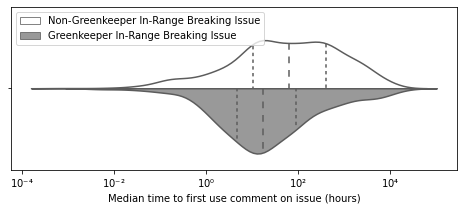

In [21]:
# Merge gk and non-gk project time to user comment by repo_name
project__all_issues__time_to_comment = projects__non_gkirbbi_with_first_user_comment.merge(
    projects__gk_issues_with_first_user_comments,
    how='inner',
    on=['repo_name'],
    suffixes=['_non_gk', '_gk'],
)
# Melt for violine plot
melted = pd.melt(
    project__all_issues__time_to_comment,
    id_vars='repo_name',
    value_vars=['median_hours_log_gk', 'median_hours_log_non_gk'],
    var_name='issue_type',
    value_name='median_time_to_comment_hours_log',
)

melted['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=melted,
    x='median_time_to_comment_hours_log',
    y='placeholder',
    hue='issue_type',
    split=True,
    inner='quartile',
    palette=['1', '0.6'],
    ax=ax,
)
ax.set_ylabel('')
ax.set_xlabel('Median time to first use comment on issue (hours)')
ax.xaxis.set_major_formatter(log10_func_formatter)
ax.legend(
    title='',
)
L = plt.legend()
L.get_texts()[0].set_text('Non-Greenkeeper In-Range Breaking Issue')
L.get_texts()[1].set_text('Greenkeeper In-Range Breaking Issue')
print('--Intra-project comparison for median time to first user comment on non-GK issues & median time to first user comment on GK in-range breaking build issues--')
tfns(project__all_issues__time_to_comment, ['median_non_gk', 'median_gk'], title='')
plt.show()

--Intra-project comparison for ratio of median time to first user comment on GK issues vs non-GK issues--
                Count      Mean      STD    Min    25%    Median     75%     Max
------------  -------  --------  -------  -----  -----  --------  ------  ------
median_ratio     1502  1014.69   19455        0  0.306     2.638  22.621  682633
mean_ratio       1502   942.253  19448.7      0  0.045     0.4     2.687  682633



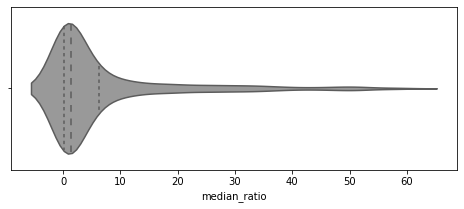

In [22]:
project__all_issues__time_to_comment['median_ratio'] = (
    project__all_issues__time_to_comment['median_gk'] / 
    project__all_issues__time_to_comment['median_non_gk']
)
project__all_issues__time_to_comment['mean_ratio'] = (
    project__all_issues__time_to_comment['mean_gk'] / 
    project__all_issues__time_to_comment['mean_non_gk']
)
for_plot = project__all_issues__time_to_comment[['median_ratio']].copy()
# Remove outliers and extemes for plot
for_plot = for_plot[for_plot['median_ratio'] < 100]
for_plot = filter_outliers(for_plot, col='median_ratio', threshold=3)

for_plot['placeholder'] = ''
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
sns.violinplot(
    data=for_plot,
    x='median_ratio',
    y='placeholder',
    inner='quartile',
    palette=['0.6'],
)
ax.set_ylabel('')
print('--Intra-project comparison for ratio of median time to first user comment on GK issues vs non-GK issues--')
tfns(project__all_issues__time_to_comment, ['median_ratio', 'mean_ratio'])
plt.show()

<h3>Bot Comments Analysis</h3>

<h3><b><i>How many issues are eventually resolved by the provider releasing a new version?</i></b></h3>

In [23]:
gk_comments = comments.loc[
    (
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]')
    )
]
failing_with_new_release_regex = 'Your tests are still failing with this version'
passing_with_new_release_regex = 'Your tests are passing again with this version'

def comment_group_saw_new_release(comment_group):
    new_release_comments = comment_group[
        (comment_group['comment_body'].str.contains(failing_with_new_release_regex)) |
        (comment_group['comment_body'].str.contains(passing_with_new_release_regex))
    ]
    return len(new_release_comments) > 0

gk_new_release_comments = gk_comments.groupby('comment_issue_id').filter(comment_group_saw_new_release)
issues_with_new_release_count = gk_new_release_comments['comment_issue_id'].nunique()
proportion = calculate_percent(issues_with_new_release_count, len(gk_issues))
print(f'{proportion}% ({issues_with_new_release_count}) of issues saw a new release of the dependency')


def issue_has_passing_with_new_release_comment(comment_group):
    new_passing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(passing_with_new_release_regex)
    ]
    return len(new_passing_release_comments) > 0

def issue_has_only_failing_new_release_comments(comment_group):
    if issue_has_passing_with_new_release_comment(comment_group):
        return False
    new_failing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(failing_with_new_release_regex)
    ]
    return len(new_failing_release_comments) > 0

passing_with_new_release = \
    gk_new_release_comments.groupby('comment_issue_id').filter(issue_has_passing_with_new_release_comment)
issues_with_passing_new_release_count = \
    passing_with_new_release['comment_issue_id'].nunique()
proportion_of_new_releases = \
    calculate_percent(issues_with_passing_new_release_count, issues_with_new_release_count)
proportion_all = \
    calculate_percent(issues_with_passing_new_release_count, len(gk_issues))
print(f'''\
{proportion_of_new_releases}% ({issues_with_passing_new_release_count}) of issues that saw a new release saw \
at least on passing release ({proportion_all}% of all issues)\
''')

only_failing_new_release = \
    gk_new_release_comments.groupby('comment_issue_id').filter(issue_has_only_failing_new_release_comments)
issues_with_only_failing_new_release_count = \
    only_failing_new_release['comment_issue_id'].nunique()
proportion_of_new_releases = \
    calculate_percent(issues_with_only_failing_new_release_count, issues_with_new_release_count)
proportion_all = \
    calculate_percent(issues_with_only_failing_new_release_count, len(gk_issues))
print(f'''\
{proportion_of_new_releases}% ({issues_with_only_failing_new_release_count}) of issues that saw a new release saw \
only failing releases ({proportion_all}% of all issues)
''')

37.87% (39298) of issues saw a new release of the dependency
18.72% (7355) of issues that saw a new release saw at least on passing release (7.09% of all issues)
81.28% (31943) of issues that saw a new release saw only failing releases (30.78% of all issues)



<h4>Issues with only failing new releases - how did the pin attempt turn out?</h4>

In [25]:
pin_attempts_from_only_failing_new_release = only_failing_new_release[only_failing_new_release['comment_body'].str.contains('after pinning to', case=False)].copy()
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_regex = '|'.join([
    "your tests are passing again"
])
pin_attempts_from_only_failing_new_release.loc[
    pin_attempts_from_only_failing_new_release['comment_body'].str.contains(pin_fail_regex, case=False),
    'pin_status'
] = 'success'
pin_attempts_from_only_failing_new_release.loc[
    pin_attempts_from_only_failing_new_release['comment_body'].str.contains(pin_success_regex, case=False),
    'pin_status'
] = 'failure'

proportions = (
    pin_attempts_from_only_failing_new_release['pin_status'].value_counts() / 
    pin_attempts_from_only_failing_new_release['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--For issues with only failing new releases, how did the pin attempt turn out?--')
proportions.head()

--For issues with only failing new releases, how did the pin attempt turn out?--


,pin_status,proportion
0,success,0.786456
1,failure,0.213544


<h4>Issues with a passing new release - how did the pin attempt turn out?</h4>

In [26]:
pin_attempts_from_passing_with_new_release = \
    passing_with_new_release[passing_with_new_release['comment_body'].str.contains('after pinning to', case=False)].copy()
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_regex = '|'.join([
    "your tests are passing again"
])
pin_attempts_from_passing_with_new_release.loc[
    pin_attempts_from_passing_with_new_release['comment_body'].str.contains(pin_fail_regex, case=False),
    'pin_status'
] = 'success'
pin_attempts_from_passing_with_new_release.loc[
    pin_attempts_from_passing_with_new_release['comment_body'].str.contains(pin_success_regex, case=False),
    'pin_status'
] = 'failure'

proportions = (
    pin_attempts_from_passing_with_new_release['pin_status'].value_counts() / 
    pin_attempts_from_passing_with_new_release['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--For issues with passing new releases, how did the pin attempt turn out?--')
proportions.head()

--For issues with passing new releases, how did the pin attempt turn out?--


,pin_status,proportion
0,failure,0.634492
1,success,0.365508


<h3>Classifying user comments</h3>

In [27]:
NOT_CLASSIFIED = 'Other'
# Set all comments to 'Not Classified'
comments['comment_classification'] = NOT_CLASSIFIED
users_comments = comments[comments['comment_user_type'] == 'User'].copy().reset_index(drop=True)
issues_with_user_comment = issues[issues['id'].isin(users_comments['comment_issue_id'])].copy().reset_index(drop=True)
percent_of_issues_with_user_comment = f'{calculate_percent(len(issues_with_user_comment), len(issues))}%'
print(f'{percent_of_issues_with_user_comment} of in-range issues have a comment from a user.')
users_comments = users_comments.drop(users_comments[pd.isna(users_comments['comment_body'])].index)

8.58% of in-range issues have a comment from a user.


In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

def clean_comment_body(c):
    text = c['comment_body']
    tokens = [t for t in text.split()]
    clean_tokens = list()
    for token in tokens:
        if token not in stopwords.words('english'):
            clean_tokens.append(lemma.lemmatize(token))
    return ' '.join(clean_tokens)

users_comments['lemm_body'] = users_comments.progress_apply(clean_comment_body, axis=1)

In [46]:
################################
# START FIX_REFERENCED
################################
FIX_REFERENCED = 'Fix Referenced'

reg_pr_url = '|'.join([
    'https:\/\/github\.com\/[\S]*\/(pull|issues)\/[\S]*'
])
reg_closed_by = '|'.join([
    '(closed|fixed|resolved|done|updated) (in|by|via|with)'
])
reg_number = '|'.join([
    '^#\d*|(Merged|Close|PR|see).*#\d*'
])

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['lemm_body'].str.contains(pat=reg_pr_url, case=True, regex=True)) |
        (users_comments['lemm_body'].str.contains(pat=reg_closed_by, case=False, regex=True)) |
        (users_comments['lemm_body'].str.contains(pat=reg_number, case=False, regex=True))
    ),
    'comment_classification'
] = FIX_REFERENCED

fix_referenced_comments = users_comments[users_comments['comment_classification'] == FIX_REFERENCED]
print(f"{calculate_percent(len(fix_referenced_comments), len(users_comments))}% of user comments explicitly link a fix.")
fix_referenced_comments[['comment_body']].sample(3)
################################
# END FIX_REFERENCED
################################

14.93% of user comments explicitly link a fix.


,comment_body
952,"Like the other failures, this was probably due to the occasional missing `.d.ts` errors that were fixed in #504. \r\n\r\nThe integration tests in #627 as well as the test added in #524 have passed multiple times with no issues."
6690,Merged in #102
1744,Caused by https://github.com/solid/solid-auth-client/issues/110


In [53]:
################################
# START FALSE_ALARM
################################
FALSE_ALARM = 'False Alarm'

reg_flaky = '|'.join([
    'flake',
    'flaky',
    'flakiness',
    'fluke',
    '(server|test|CI) hiccup',
    'inconsistent test',
    'brittle test',
    'unstable unit test',
    'unstable test',
    'Spurious test failure',
    'Tests are passing',
    'tests are actually passing',
])
reg_random = '|'.join([
    '(fail|failing) random',
    'random.*fail.*',
    'random build error',
    'intermittent',
])
reg_retrigger = '|'.join([
    'retrigger',
    're-trigger',
    'rebuild',
    're-build',
    'restart',
    're-starting',
    're-run',
    'retried',
    'rerun',
    'reran',
    're-ran',
])
reg_false_positive = '|'.join([
    'false (positive|alarm|negative|alert)',
    'falso positive',
])
reg_invalid = '|'.join([
    '^(invalid|not applicable|not (a|an) issue|unrelated)',
    'Couldn\'t reproduce',
    'all tests pass',
])
reg_unrelated = '|'.join([
    '(unrelated.*fail)',
    'failed for other reasons',
    'build is actually passing',
    'build hiccup',
])
reg_timeout = '|'.join([
    'timeout|time-out',
])

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['lemm_body'].str.contains(pat=reg_flaky, case=False, regex=True)) |
        (users_comments['lemm_body'].str.contains(pat=reg_random, case=False, regex=True)) |
        (users_comments['lemm_body'].str.contains(pat=reg_retrigger, case=False, regex=True)) |
        (users_comments['lemm_body'].str.contains(pat=reg_false_positive, case=False, regex=True)) | 
        (users_comments['lemm_body'].str.contains(pat=reg_invalid, case=False, regex=True)) |
        (users_comments['lemm_body'].str.contains(pat=reg_unrelated, case=False, regex=True)) |
        (users_comments['lemm_body'].str.contains(pat=reg_timeout, case=False, regex=True))
    ),
    'comment_classification'
] = FALSE_ALARM


false_alarm_comments = users_comments[users_comments['comment_classification'] == FALSE_ALARM]
print(f"{calculate_percent(len(false_alarm_comments), len(users_comments))}% of user comments indicate a false alarm.")
false_alarm_comments[['comment_body']].sample(10)
################################
# END FALSE_ALARM
################################

18.47% of user comments indicate a false alarm.


,comment_body
1211,false positive
2833,Timeout in CI.
1625,False alarm by AppVeyor.
6214,force rebuild
8204,"This is branches off wrong commit (actually it’s just a built timeout), should be fine when merging."
9392,False negative
10014,flaky test
4218,Flaky CI.
3963,Unrelated - closing...
6303,Reran tests and this went away - looks like it was a false positive caused by npm.org being inaccessible.


In [32]:
################################
# START TRANSIENT_FAILURE
################################
TRANSIENT_FAILURE = 'Transient Failure'

reg_transient = '|'.join([
    'transient.*fail',
])

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['lemm_body'].str.contains(pat=reg_transient, case=False, regex=True))
    ),
    'comment_classification'
] = TRANSIENT_FAILURE

transient_failure_comments = users_comments[users_comments['comment_classification'] == TRANSIENT_FAILURE]
print(f"{calculate_percent(len(transient_failure_comments), len(users_comments))}% of user comments saying failure was caused by transient dependency")
# transient_failure_comments['comment_body'].sample(10)
################################
# END TRANSIENT_FAILURE
################################

0.26% of user comments saying failure was caused by transient dependency


In [33]:
################################
# START MENTION_GREENKEEPER
################################
MENTION_GREENKEEPER = 'Mention Greenkeeper'

reg_greenkeeper = '|'.join([
    'greenkeeper',
])

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['lemm_body'].str.contains(pat=reg_greenkeeper, case=False, regex=True))
    ),
    'comment_classification'
] = MENTION_GREENKEEPER

mention_greenkeeper_comments = users_comments[users_comments['comment_classification'] == MENTION_GREENKEEPER]
print(f"{calculate_percent(len(mention_greenkeeper_comments), len(users_comments))}% of user comments mentioning Greenkeeper")
# mention_greenkeeper_comments['comment_body'].sample(10)
################################
# END MENTION_GREENKEEPER
################################

3.46% of user comments mentioning Greenkeeper


In [34]:
################################
# START MENTION_CI_SYSTEM
################################
MENTION_CI_SYSTEM = 'Mention CI System'

reg_ci_system = '|'.join([
    'travis',
    'CircleCI',
    'circle ci',
    'jarvis',
    'jenkins',
    'CI.*issue',
])

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['lemm_body'].str.contains(pat=reg_ci_system, case=False, regex=True))
    ),
    'comment_classification'
] = MENTION_CI_SYSTEM

mention_ci_system_comments = users_comments[users_comments['comment_classification'] == MENTION_CI_SYSTEM]
print(f"{calculate_percent(len(mention_ci_system_comments), len(users_comments))}% of user comments mention the projects CI build system")
# mention_greenkeeper_comments['comment_body'].sample(10)
################################
# END MENTION_CI_SYSTEM
################################

4.7% of user comments mention the projects CI build system


In [49]:
################################
# START FIX_MENTIONED
################################
FIX_MENTIONED = 'Fix Mentioned'

reg_fixed = '(fix(ed)*|resolved|done|solved|closed|updated|upgraded|closing|merged)|(fix|fixed|bumped|merged|upgraded).*manually|manually.*merged'
reg_update_in = '.*update.*in.*|Making a PR'

users_comments.loc[
    (users_comments['comment_classification'] == NOT_CLASSIFIED) & (
        (users_comments['lemm_body'].str.contains(pat=reg_fixed, case=False, regex=True)) | 
        (users_comments['lemm_body'].str.contains(pat=reg_update_in, case=False, regex=True))
    ),
    'comment_classification'
] = FIX_MENTIONED

fix_mentioned_comments = users_comments[users_comments['comment_classification'] == FIX_MENTIONED]
print(f"{calculate_percent(len(fix_mentioned_comments), len(users_comments))}% of user comments saying the issues has been fixed (without linking the fix).")
fix_mentioned_comments[['comment_body']].sample(10)
################################
# END FIX_MENTIONED
################################

36.5% of user comments saying the issues has been fixed (without linking the fix).


,comment_body
2028,fixed
6407,fixed
26,Fixed in 851f37b43b9143163d884cfae0946290da731f7a
2646,Fixed in #8
6892,The issue was fixed in #26
4425,Fixed in 8cea5c47c5bcb982d2ddb802d2c0070cc416e3e5
9830,Fixed in 68f12fa
6695,Fixed by #109
3290,Fixed in 8636b21544746349486a47bc59e98961af1b6bb2
1124,Resolved in #41


In [36]:
# TODO: Classify others
# users_comments[users_comments['comment_classification'] == NOT_CLASSIFIED][['comment_body']].sample(10)

